
## 1. Setup Mario

In [25]:
train = False

In [26]:
#game from openAI gym
import gym_super_mario_bros
#joypad wrapper
from nes_py.wrappers import JoypadSpace
#simplified controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [27]:
#Create a flag - restart (true) or not?
# done = True
# #loop trhough each fram in the game
# for step in range(100000):
#     if done: 
#         #start the game
#         env.reset()
#     #env.action_space.sample() = do random actions
#     state, reward, done, info = env.step(env.action_space.sample())
#     #show the game
#     env.render()
# #close the
# env.close()

In [28]:
# state = env.reset()
#frame after the step
# env.step(1)[0]
# #reward function => move mario as far and as right as possible
# print("{} {}".format("Is action rewarding? =", env.step(1)[1]))
# #dead or alive
# print("{} {}".format("Is Mario dead? =", env.step(1)[2]))
# #more infos
# print(env.step(1)[3])

## 2. Preprocess Environment
#### Rubbish data = Rubbish AI !

In [29]:
# import frame stackewr wrapper and grayscaling
from gym.wrappers import GrayScaleObservation
#import vectorizzation wrappert 
# conda install opencv
# conda install pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch
#RL stable_baselines3 library 
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv

#check CUDA availiability
from torch.cuda import is_available

if not is_available():
    raise ValueError("no CUDA!")
#to visualize
from matplotlib import pyplot as plt

In [30]:
#1. setup game base environnement
env = gym_super_mario_bros.make('SuperMarioBros-v0')
# env.action_space

#2. reduce action space to something managable
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# print(env.action_space)
# #show possible actions
# SIMPLE_MOVEMENT

#3. Grayscale
env = GrayScaleObservation(env, keep_dim=True)

#4. wrap inside the dummy env
env = DummyVecEnv([lambda: env])

#5. stack up the frame
env = VecFrameStack(env, 4, channels_order="last")

In [31]:
state = env.reset()

In [32]:
state.shape
state, reward, done, info = env.step([env.action_space.sample()])

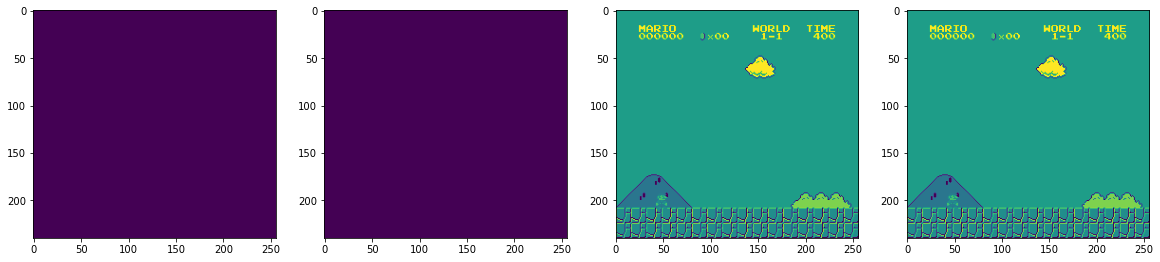

In [33]:
#pot it out
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

## 3. Train the RL model
#### Here using the PPO (Proximal policy oprimizer) algorythm form OpenAI

In [34]:
import os
from stable_baselines3 import PPO
#import base callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
#conda install tensorboard

In [35]:
# nice wrapper to save callbacks easilly
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [36]:
#setup directories to save stuff
CHECKPOINT_DIR = "./train/"
LOGS_DIR = "./logs/"

try:
    os.stat(CHECKPOINT_DIR)
except:
    list_ = ['logs', 'train']
    for folder in list_:
        os.makedirs(folder)

#every 10'000 step it saves the model
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [37]:
#specify training with convolutional neural network (CNN)
model = PPO("CnnPolicy", env, verbose=1, 
    tensorboard_log=LOGS_DIR, learning_rate=0.000001, n_steps=512)


Using cuda device
Wrapping the env in a VecTransposeImage.


In [39]:
if train:
    #start training
    model.learn(total_timesteps=1000000, callback=callback)
    #want to see you LOSS going DOWN and your EXPLAINED VARIANCE going UP

    #type tensorboard --logdir=. in the logs output to visualize learning

-------------------------------------------
| time/                   |               |
|    fps                  | 87            |
|    iterations           | 599           |
|    time_elapsed         | 3504          |
|    total_timesteps      | 306688        |
| train/                  |               |
|    approx_kl            | 0.00042634958 |
|    clip_fraction        | 0.000586      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.735        |
|    explained_variance   | 0.825         |
|    learning_rate        | 1e-06         |
|    loss                 | 77.3          |
|    n_updates            | 5980          |
|    policy_gradient_loss | -0.000877     |
|    value_loss           | 159           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 87           |
|    iterations           | 600          |
|    time_elapsed         | 3510    

## 4. Test out the model

In [19]:
#load best model
model = PPO.load('./train/best_model_90000')

In [ ]:
#start the game
state = env.reset()

#loop trhough the game
while True:
    #get berst action for each state
    action, state = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()

In [21]:
env.close()